Load data for network from file

In [265]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from pprint import pprint
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import json
%matplotlib inline


In [266]:
wine = np.genfromtxt("datasets/wine/wine_train_array.csv", delimiter=',')


In [267]:
wine[0]

array([0.59210526, 0.17786561, 0.79569892, 0.25257732, 0.43478261,
       0.55862069, 0.68823529, 0.42      , 0.29746835, 0.28327645,
       0.49593496, 0.56981132, 0.48666128, 1.        , 0.        ,
       0.        ])

In [268]:
X = wine[:,:-3]
Y = wine[:,-3:]

In [269]:
X[0]

array([0.59210526, 0.17786561, 0.79569892, 0.25257732, 0.43478261,
       0.55862069, 0.68823529, 0.42      , 0.29746835, 0.28327645,
       0.49593496, 0.56981132, 0.48666128])

In [270]:
Y[0]

array([1., 0., 0.])

In [271]:
#train_x,train_y,test_x,test_y = create_feature_sets_and_labels('Data/pos.txt','Data/neg.txt')
train_x = X
train_y = Y



In [272]:
class TfAnn(object):
    
    def __init__(self,layers,n_classes):
        self.hidden=[]
        self.np_hidden=[]
        
        self.n_nodes=[]
        self.n_classes = n_classes
        self.n_hiden_layers = len(layers)
        for i in range(self.n_hiden_layers):
            self.hidden.append({'weights':[],'biases':[]})
            self.np_hidden.append({'weights':[],'biases':[]})
            self.n_nodes.append(layers[i])
        self.output_layer = {'weights':[],'biases':[]}
        self.np_output_layer={"weights":[],"biases":[]}
    
    def init_empty(self,size):
        for i in range(self.n_hiden_layers):
            self.hidden[i] = {'weights':tf.Variable(tf.random_normal([size, self.n_nodes[i]])),
                      'biases':tf.Variable(tf.random_normal([self.n_nodes[i]]))}
            
        self.output_layer = {'weights':tf.Variable(tf.random_normal([self.n_nodes[-1], self.n_classes])),
                        'biases':tf.Variable(tf.random_normal([self.n_classes]))}


#    def init_values(self,size,l1_weights,l2_weights,l3_weights,out_weights,l1_biases,l2_biases,l3_biases,out_biases):
#        self.hidden_1_layer = {'weights':tf.Variable(l1_weights),'biases':tf.Variable(l1_biases)}
#        self.hidden_2_layer = {'weights':tf.Variable(l2_weights),'biases':tf.Variable(l2_biases)}
#        self.output_layer = {'weights':tf.Variable(out_weights),'biases':tf.Variable(out_biases)}


    def create(self,data):
        # This is the heart of the ann where multiply the data by the wights to the layers 
        for i in range(self.n_hiden_layers):
            layer = tf.add(tf.matmul(data,self.hidden[i]['weights']), self.hidden[i]['biases'])
            layer= tf.nn.relu(layer)
        output =  tf.add(tf.matmul(layer,self.output_layer['weights']) , self.output_layer['biases'])
        return output
    
    def extract(self):
        for i in range(self.n_hiden_layers):
            self.np_hidden[i]["weights"] = neural_network_model.hidden[i]["weights"].eval()
            self.np_hidden[i]["biases"] = neural_network_model.hidden[i]["biases"].eval()
        self.np_output_layer["weights"] = neural_network_model.output_layer["weights"].eval()
        self.np_output_layer["biases"] = neural_network_model.output_layer["biases"].eval()
        return json.dumps({"hidden":self.np_hidden,"output":self.np_output_layer}, ensure_ascii=False)
        
        

In [273]:
def train_neural_network_interactive(neural_network_model,fold):
    x= tf.placeholder('float')
    y = tf.placeholder('float')
    prediction = neural_network_model.create(x)
    cost = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=y) )
    optimizer = tf.train.AdamOptimizer().minimize(cost)
    hm_epochs = 2500
    sess = tf.InteractiveSession()
    init = tf.initialize_all_variables()
    sess.run(init)
    losses=[]
    for epoch in range(hm_epochs):
            _, c = sess.run([optimizer, cost], feed_dict={x: train_x[train_index[fold]],
                                                          y: train_y[train_index[fold]]})
            losses.append(c)

    y_test=(sess.run(prediction,feed_dict={
                             x: train_x[test_index[fold]]
                              }))       
    
    true_class=np.argmax(train_y[test_index[fold]],1)
    predicted_class=np.argmax(y_test,1)
    return confusion_matrix(predicted_class,true_class),losses
   

In [274]:
from sklearn.model_selection import StratifiedKFold
train_index=[]
test_index=[]
splits =5
skf = StratifiedKFold(n_splits=splits,random_state=0,shuffle=True)
for train_idx, test_idx in skf.split(train_x,train_y[:,0]):               
    train_index.append(train_idx)
    test_index.append(test_idx)

/home/ric/Projects/Python/env/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


array([[ 9,  0,  0],
       [ 1, 12,  0],
       [ 0,  0,  7]])


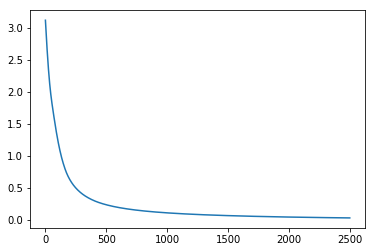

array([[10,  0,  0],
       [ 0,  8,  0],
       [ 0,  0, 11]])


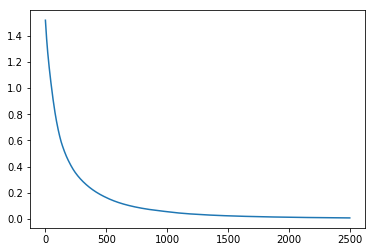

array([[ 9,  0,  0],
       [ 0, 13,  0],
       [ 0,  0,  6]])


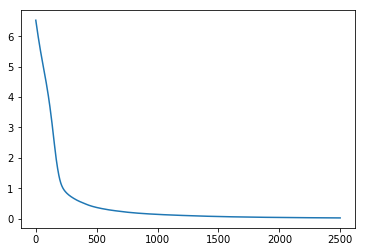

array([[ 9,  0,  0],
       [ 0, 11,  0],
       [ 0,  0,  8]])


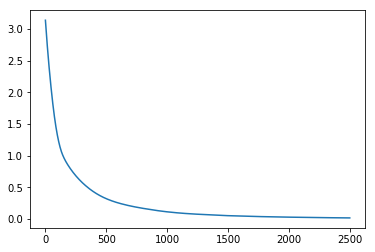

array([[ 9,  0,  0],
       [ 0, 13,  0],
       [ 0,  0,  6]])


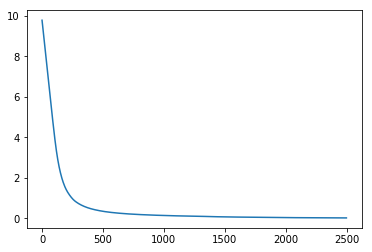

In [275]:
for i in range(splits):
    neural_network_model = TfAnn([13],len(train_y[0]))
    neural_network_model.init_empty(len(train_x[0]))
    cf,loss = train_neural_network_interactive(neural_network_model,i)
    pprint(cf)
    plt.plot(loss)
    plt.show()